```{admonition} Lecture Materials
:class: tip
[Download the slide deck for this lecture](/_static/pdf/Lecture12-OrdinaryDifferentialEquations-2.pdf)
```

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def ode_euler_step(f, x, t, h):
    """Perform a single step h using Euler's scheme.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    return x + h * f(x,t)


def ode_rk2_step(f, x, t, h):
    """Perform a single step h using 2nd order Runge-Kutta scheme.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    k1 = h * f(x,t)
    k2 = h * f(x + k1/2., t + h /2.)
    return x + k2

def ode_euler_multi(f, x0, t0, h, nsteps):
    """Multi-dimensional version of the Euler method.
    """
    
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    t[0] = t0
    x[0,:] = x0
    for i in range(0, nsteps):
        t[i + 1] = t[i] + h
        x[i + 1,:] = ode_euler_step(f, x[i], t[i], h)
    return t,x

def ode_rk2_multi(f, x0, t0, h, nsteps):
    """Multi-dimensional version of the RK2 method.
    """
    
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    t[0] = t0
    x[0,:] = x0
    for i in range(0, nsteps):
        t[i + 1] = t[i] + h
        x[i + 1] = ode_rk2_step(f, x[i], t[i], h)
    return t,x

def ode_rk4_step(f, x, t, h):
    """Perform a single step h using 4th order Runge-Kutta method.

    Args:
    f: the function that defines the ODE.
    x: the value of the dependent variable at the present step.
    t: the present value of the time variable.
    h: the time step

    Returns:
    xnew: the value of the dependent variable at the step t+h
    """
    k1 = h * f(x,t)
    k2 = h * f(x + k1/2., t + h /2.)
    k3 = h * f(x + k2/2., t + h /2.)
    k4 = h * f(x + k3, t + h)
    return x + (k1 + 2. * k2 + 2. * k3 + k4) / 6.
    
def ode_rk4_multi(f, x0, t0, h, nsteps):
    """Multi-dimensional version of the RK4 method.
    """
    
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    t[0] = t0
    x[0] = x0
    for i in range(0, nsteps):
        t[i + 1] = t[i] + h
        x[i + 1] = ode_rk4_step(f, x[i], t[i], h)
    return t,x

# The default definition of the error (distance) between two state vectors 
# Default: the magnitude of the difference vector
def distance_definition_default(x1, x2):
    diff = x1 - x2
    diffnorm = np.sqrt(np.dot(diff, diff))
    return diffnorm

def ode_rk4_adaptive_multi(f, x0, t0, h0, tmax, delta = 1.e-6, distance_definition = distance_definition_default):
    """Solve an ODE dx/dt = f(x,t) from t = t0 to t = t0 + h*steps 
    using 4th order Runge-Kutta method with adaptive time step.

    Args:
          f: the function that defines the ODE.
         x0: the initial value of the dependent variable.
         t0: the initial value of the time variable.
         h0: the initial time step
       tmax: the maximum time
      delta: the desired accuracy per unit time

    Returns:
    t,x: the pair of arrays corresponding to the time and dependent variables
    """
    
    ts = [t0]
    xs = [x0]
    
    h = h0
    t = t0
    i = 0
        
    while (t < tmax):
        if (t + h >= tmax):
            ts.append(tmax)
            h = tmax - t
            xs.append(ode_rk4_step(f, xs[i], ts[i], h))
            t = tmax
            break
        
        x1 = ode_rk4_step(f, xs[i], ts[i], h)
        x1 = ode_rk4_step(f, x1, ts[i] + h, h)
        x2 = ode_rk4_step(f, xs[i], ts[i], 2*h)
        
        diffnorm = distance_definition(x1, x2)
        if diffnorm == 0.: # To avoid the division by zero
            rho = 2.**4
        else:
            rho = 30. * h * delta / diffnorm
        if rho < 1.:
            h *= rho**(1/4.)
        else:
            if (t + 2.*h) < tmax:
                xs.append(x1)
                ts.append(t + 2*h)
                t += 2*h
            else:
                xs.append(ode_rk4_step(f, xs[i], ts[i], h))
                ts.append(t + h)
                t += h
            i += 1
            h = min(2.*h, h * rho**(1/4.))
        
    return ts,xs

# Time-reversal methods

## Leapfrog method

```{figure} fig8-9-leapfrog.png
:width: 500px
:align: center
:name: fig-leapfrog
```
<center>
    (a) 2nd-order Runge-Kutta<br/>
    (b) Leapfrog<br/>
    Source: M. Newman "Computational Physics"
</center>

Recall the 2nd order Runge-Kutta (midpoint) method.

The full step proceeds by evaluating

$$
x(t+h) = x(t) + h f[x(t+h/2),t+h/2],
$$

where the midpoint value $x(t+h/2)$ is estimated using Euler's method

$$
x(t+h/2) = x(t) + \frac{1}{2} h f(x,t)~.
$$

The idea of the leapfrog method is to use the last equation (Euler half-step) only in the first iteration, and then use the first equation to estimate both $x(t+h)$ and $x(t+3h/2)$, i.e., given the values of $x(t)$ and $x(t+h/2)$ at each step the algorithm calculates a pair of values
\begin{align*}
x(t+h) &= x(t) + h f[x(t+h/2),t+h/2], \\
x(t+3h/2) &= x(t+h/2) + h f[x(t+h),t+h].
\end{align*}

The attractive feature of this algorithm is that it is *time reversible*. By changing $h \to -h$ one gets
\begin{align*}
x(t-h) &= x(t) - h f[x(t-h/2),t-h/2], \\
x(t-3h/2) &= x(t-h/2) - h f[x(t-h),t-h],
\end{align*}
i.e. the same steps are performed in reverse.
Changing $t \to t + 3h/2$ one gets
\begin{align*}
x(t+h/2) &= x(t+3h/2) - h f[x(t+h),t+h], \\
x(t) &= x(t+h) - h f[x(t+h/2),t+h/2],
\end{align*}

The time reversal symmetry is important since the microscopic equations are typically time-reversal, so it is good to have this feature built-in by construction in the numerical scheme.

In [20]:
def ode_leapfrog_step(f, x, x2, t, h):
    """Perform a single step h using the leapfrog method.

    Args:
     f: the function that defines the ODE.
     x: the value of x(t)
    x2: the value of x(t+h/2)
     t: the present value of the time variable.
     h: the time step

    Returns:
    xnew, xnew2: the value of the dependent variable at the steps t+h, t+3h/2
    """
    
    xnew = x + h * f(x2,t+h/2.)
    xnew2 = x2 + h * f(xnew, t + h)
    return xnew, xnew2

def ode_leapfrog_multi(f, x0, t0, h, nsteps):
    """Multi-dimensional version of the leapfrog method.
    """
    
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    x2 = np.zeros(len(x0))
    t[0] = t0
    x[0,:] = x0
    x2[:] = ode_euler_step(f, x0, t0, h/2.)
    for i in range(0, nsteps):
        t[i + 1] = t[i] + h
        x[i + 1], x2 = ode_leapfrog_step(f, x[i], x2, t[i], h)
    return t,x

Let us return to the problem of a non-linear pendulum and apply the leap-frog method.
We can monitor the behavior of the energy

$$
E = m L^2 \dot{\theta}^2/2 - mgL \cos(\theta)
$$

as a function of time.

If $\theta_0 = \pi/2$ and $\dot{\theta}_0 = 0$ the total energy is zero.

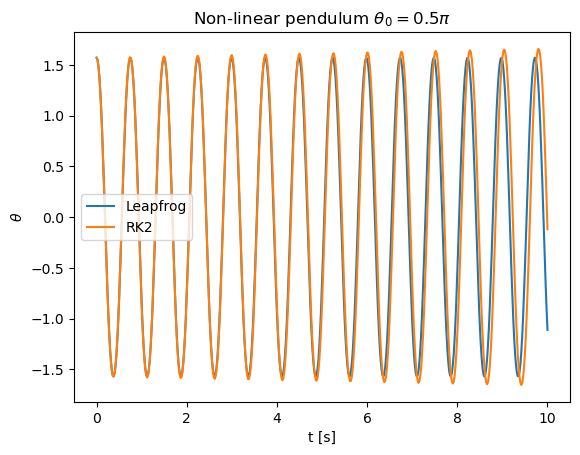

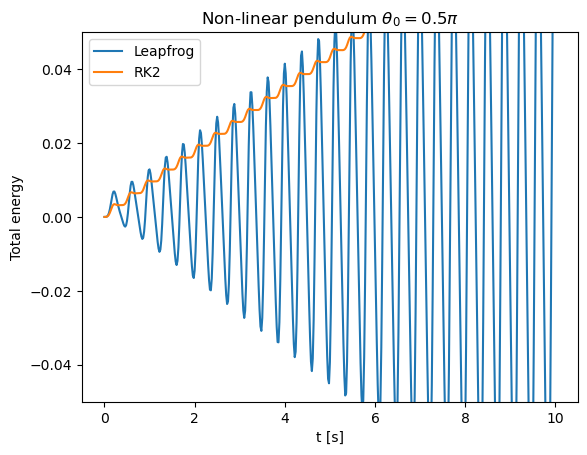

In [21]:
g = 9.81 # m/s^2
L = 0.1  # m

def fpendulum(xin, t):
    theta = xin[0]
    omega = xin[1]
    return np.array([omega,-g/L * np.sin(theta)])
    #return np.array([omega,-g/L * theta])

# The energy of a pendulum
def pendulum_energy(x):
    return L*L*x[1]**2/2. - g*L*np.cos(x[0])
    #return L*L*x[1]**2/2. - g*L*x[0]**2/2.


theta0 = (90./180.) * np.pi
omega0 = 0.

x0 = np.array([theta0,omega0])
a = 0.
b = 10.
N = 500
h = (b-a)/N

sol_leapfrog = ode_leapfrog_multi(fpendulum, x0, a, h, N)
sol_rk2 = ode_rk2_multi(fpendulum, x0, a, h, N)
tpoints = sol_leapfrog[0]
xpoints = sol_leapfrog[1][:,0]
ypoints = sol_leapfrog[1][:,1]

xpoints_rk2 = sol_rk2[1][:,0]

def theta_small_angles(t):
    return theta0 * np.cos(np.sqrt(g/L) * t)

xpoints_small = theta_small_angles(tpoints)

plt.title("Non-linear pendulum ${\\theta_0 = " + str(theta0/np.pi) + "\pi}$")
plt.xlabel('t [s]')
plt.ylabel('${\\theta}$')
plt.plot(tpoints,xpoints,label='Leapfrog')
plt.plot(tpoints,xpoints_rk2,label='RK2')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

energies_leapfrog = [pendulum_energy(x) for x in sol_leapfrog[1]]
energies_rk2 = [pendulum_energy(x) for x in sol_rk2[1]]

plt.title("Non-linear pendulum ${\\theta_0 = " + str(theta0/np.pi) + "\pi}$")
plt.xlabel('t [s]')
plt.ylabel('Total energy')
#plt.ylim(-2,2)
plt.ylim(-0.05,0.05)
plt.plot(tpoints,energies_leapfrog,label='Leapfrog')
plt.plot(tpoints,energies_rk2,label='RK2')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

The leapfrog method shows greater stability as the average energy is conserved.
Such a method is thus particularly suitable for long simulations of periodic systems.

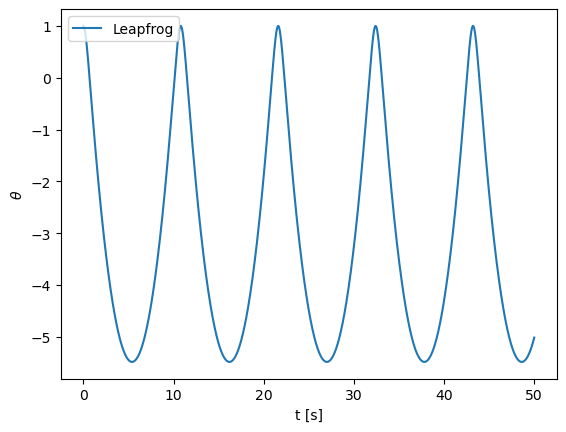

In [22]:
# Exercise 8.11

def fpendulum(xin, t):
    theta = xin[0]
    omega = xin[1]
    return np.array([omega,omega**2 - theta - 5])
    #return np.array([omega,-g/L * theta])

theta0 = 1.
omega0 = 0.

x0 = np.array([theta0,omega0])
a = 0.
b = 50.
N = 50000
h = (b-a)/N
h = 0.001

sol_leapfrog = ode_leapfrog_multi(fpendulum, x0, a, h, N)
sol_rk2 = ode_rk2_multi(fpendulum, x0, a, h, N)
tpoints = sol_leapfrog[0]
xpoints = sol_leapfrog[1][:,0]
ypoints = sol_leapfrog[1][:,1]

xpoints_rk2 = sol_rk2[1][:,0]

def theta_small_angles(t):
    return theta0 * np.cos(np.sqrt(g/L) * t)

xpoints_small = theta_small_angles(tpoints)

plt.xlabel('t [s]')
plt.ylabel('${\\theta}$')
plt.plot(tpoints,xpoints,label='Leapfrog')
#plt.plot(tpoints,xpoints_rk2,label='RK2')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

## Verlet method

Suppose we are solving Newton's equations of motion

$$
\frac{d^2 x}{dt^2} = f(x,t).
$$

These are rewritten as
\begin{align*}
\frac{dx}{dt} &= v, \\
\frac{dv}{dt} &= f(x,t).
\end{align*}

If we apply the leapfrog scheme to this system of equations, it will look like
\begin{align*}
x(t+h) & = x(t) + h v(t + h/2), \\
v(t+3h/2) &= v(t+h/2) + h f[x(t+h), t+h)],
\end{align*}
i.e. the coordinates are evaluated are full steps using velocity estimates at half-steps,
and vice versa.

This is the essence of the Verlet method.
It's feature is that we do not need to keep track of coordinates at half-steps (only the velocities) and of velocities at full steps. In case we are interested in velocity values also at full step, these can be estimated as $v(t+h) = v(t+h/2) + (h/2) f[x(t+h),t+h]$.

The full algorithm is as follows. Given initial values $x(t)$ and $v(t)$ one first computes

$$
v(t+h/2) = v(t) + \frac{h}{2} f[x(t),t].
$$

Then each step of the Verlet algorithm corresponds to
\begin{align*}
x(t+h) & = x(t) + h v(t+h/2), \\
k & = h f[x(t+h),t+h), \\
v(t+h) & = v(t+h/2) + k/2, \\
v(t+3h/2) & = v(t+h/2) + k.
\end{align*}

The algorithm is straightforwardly generalizable to more than one variable.

## Modified midpoint method

Recall that steps in the leapfrog method are time-reversible ($h \to -h$).
For this reason the local error (per one step) contains only odd powers of $h$,
while the global error integrating from $t$ to $t+H$ would have only even powers of $h$.
The only issue is the first Euler half-step $x(t+h/2) = x(t) + (h/2)f(x,t)$ which is not symmetric in $h$.
This half-step ruins the desired property of the global error containing only even powers of $h$.

To fix this issue one uses an extra step at the very end,
which is called the modified midpoint method.
Let $y_n = x(t+H-h/2)$ and $x_n = x(t+H)$ be the estimates of the solution resulting from the leapfrog method.
One then re-evaluates $x(t+H)$ as an average of $x_n$ and the $x(t+H)$ evaluated using Euler half-step from $y_n$:

$$
x(t+H) = \frac{1}{2} [x_n + y_n + \frac{h}{2} f(x_n,t+H)].
$$

This modification cancels all odd terms in the global error for $x(t+H)$.

In [23]:
def ode_MMM_multi(f, x0, t0, H, nsteps):
    """Multi-dimensional version of the modified midpoint method.
    """
    
    h = H / nsteps
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    x2 = np.zeros(len(x0))
    t = t0
    x = x0
    y = ode_euler_step(f, x0, t0, h/2.)
    for i in range(0, nsteps):
        yprev = y
        x, y = ode_leapfrog_step(f, x, y, t, h)
        t = t + h
        
    return 0.5 * (x + yprev + 0.5 * h * f(x,t))

## Bulirsch-Stoer method

Bulirsch-Stoer method is an analogue of Romberg integration applied to ODE.
The method allows one to integrate a (system) of ODE for $t$ to $t+H$ to desired accuracy.
To achieve that one uses the modified midpoint method with increasing number of steps,
and the difference between the subsequent steps to cancel out higher and higher-order error terms in $h$.

The iterative procedure is as follows.
Let $R_{n,1}$ be an estimate of $x(t+H)$ from the modified midpoint method using $n$ steps of size $h_n = H/n$.
Then

$$
x(t+H) = R_{n,1} + O(h_n^2).
$$

One constructs high-order approximations $R_{n,m}$ such that

$$
x(t+H) = R_{n,m} + O(h_n^{2m}),
$$

from the following iterative procedure

$$
R_{n,m+1} = R_{n,m} + \frac{R_{n,m} - R_{n-1,m}}{[n/(n-1)]^{2m} - 1}~.
$$

The procedure goes one in incremental steps of $n$ until the distane between the solution estimates $R_{n,n}$ and $R_{n,n-1}$ reaches the desired accuracy.

In practice, if the desired accuracy is not reached after $n \sim 10$ steps, it may indicate that $H$ is too large, and one has to split it into two subintervals of width $H/2$ and apply the Bulirsch-Stoer method recursively.

In [24]:
def bulirsch_stoer_step(f, x0, t0, H, delta = 1.e-6, distance_definition = distance_definition_default, maxsteps = 10):
    """Use Bulirsch-Stoer method to integrate for t to t+H.
    """
    n = 1
    R1 = np.empty([1,len(x0)],float)
    R1[0] = ode_MMM_multi(f, x0, t0, H, 1)
    error = 2. * H * delta
    while error > H*delta and n < maxsteps:
        n += 1
        R2 = R1
        R1 = np.empty([n,len(x0)],float)
        R1[0] = ode_MMM_multi(f, x0, t0, H, n)
        for m in range(1,n):
            epsilon = (R1[m-1]-R2[m-1])/((n/(n-1))**(2*m)-1)
            R1[m] = R1[m-1] + epsilon
        error = distance_definition(R1[n-2],R1[n-1])
        
    if n == maxsteps:
        # Reached maximum number of substeps in Bulirsch-Stoer method
        # reducing the time step and applying the method recursively
        sol1 = bulirsch_stoer_step(f, x0, t0, H/2., delta, distance_definition, maxsteps)
        sol2 = bulirsch_stoer_step(f, sol1[-1][1], t0 + H/2., H/2., delta, distance_definition, maxsteps)
        return sol1 + sol2
    
    return [[t0+H, R1[n - 1]]]

In [26]:
def bulirsch_stoer(f, x0, t0, nsteps, tmax, delta = 1.e-6, distance_definition = distance_definition_default, maxsubsteps = 10):
    """Use Bulirsch-Stoer method to integrate for t to tmax using nsteps Bulirsch-Stoer steps
    """
    H = (tmax - t0) / nsteps
    t = np.zeros(nsteps + 1)
    x = np.zeros((len(t), len(x0)))
    t = [t0]
    x = [x0]
    for i in range(0, nsteps):
        bst = bulirsch_stoer_step(f, x[-1], t[-1], H, delta, distance_definition, maxsubsteps)
        [t.append(el[0]) for el in bst]
        [x.append(el[1]) for el in bst]
    return t,x

Let us apply the Bulirsch-Stoer method to solve the motion of non-linear pendulum.
Due to the fact that the method dynamically adjusts $H$ to reach the desired accuracy, we can start with just one step.

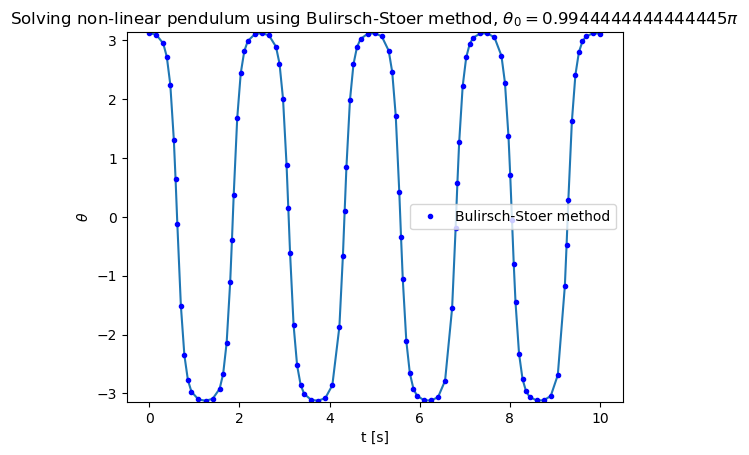

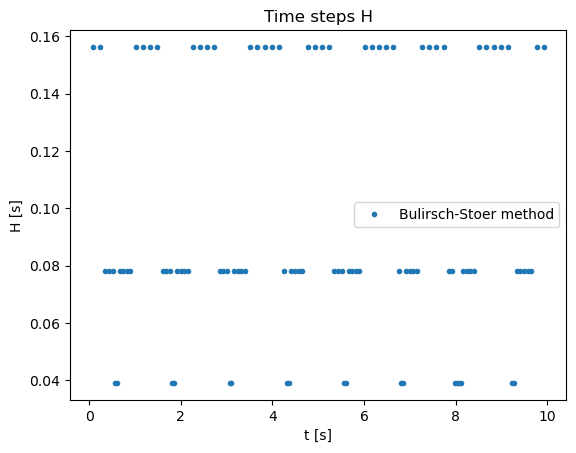

In [27]:
g = 9.81
L = 0.1

def fpendulum(xin, t):
    theta = xin[0]
    omega = xin[1]
    return np.array([omega,-g/L * np.sin(theta)])

def error_definition_pendulum(x1, x2):
    return np.abs(x1[0] - x2[0])

theta0 = 179. * np.pi / 180.
omega0 = 0.
x0 = np.array([theta0,omega0])
a = 0.
b = 10.0
N = 1
eps = 1.e-8
maxsubsteps = 10

sol = bulirsch_stoer(fpendulum, x0, a, N, b, eps, error_definition_pendulum, maxsubsteps)

tpoints = [t for t in sol[0]]
xpoints = [x[0] for x in sol[1]]
ypoints = [x[1] for x in sol[1]]


plt.title("Solving non-linear pendulum using Bulirsch-Stoer method, ${\\theta_0 = " + str(theta0/np.pi) + "\pi}$")
plt.xlabel('t [s]')
plt.ylabel('${\\theta}$')
plt.plot(tpoints,xpoints)
plt.plot(tpoints,xpoints,'b.',label='Bulirsch-Stoer method')
plt.ylim(-np.pi,np.pi)
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

thpoints = []
hpoints = []
for i in range(len(tpoints) - 1):
    thpoints.append(0.5*(tpoints[i] + tpoints[i+1]))
    hpoints.append(tpoints[i+1] - tpoints[i])
    
plt.title("Time steps H")
plt.xlabel('t [s]')
plt.ylabel('H [s]')
plt.plot(thpoints,hpoints,'.',label='Bulirsch-Stoer method')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

Let us now apply the Bulirsch-Stoer method to analyze the comet motion.
Again, we can use a single step $H$ initially

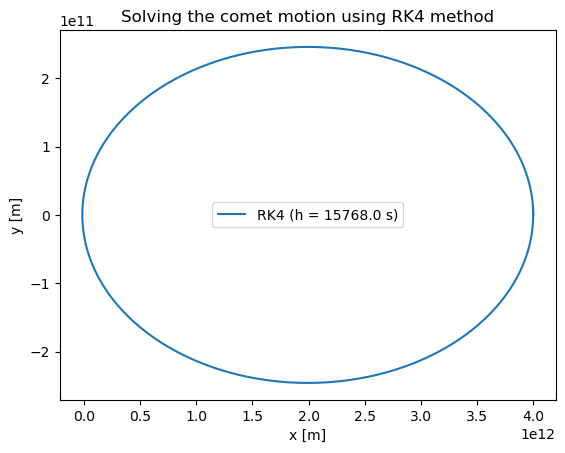

In [34]:
G = 6.67430e-11  # m^3 / kg / s^2
Msun = 1.9885e30 # kg

def fcomet(xin, t):
    x = xin[0]
    y = xin[1]
    vx = xin[2]
    vy = xin[3]
    r = np.sqrt(x*x+y*y)
    return np.array([vx,vy,-G*Msun*x/r**3,-G*Msun*y/r**3])

x0 = [4.e12,0.,0.,500.]

a = 0.
b = 50. * 365. * 24. * 60. * 60. # 50 years
N = 100000                       # 100 thousand RK4 steps
h = (b - a) / N                  # Time step: around 1/5th of a day
sol = ode_rk4_multi(fcomet, x0, a, h, N)

tpoints_rk4_ref = sol[0]
xpoints_rk4_ref = sol[1][:,0]
ypoints_rk4_ref = sol[1][:,1]
vxpoints_rk4_ref = sol[1][:,2]
vypoints_rk4_ref = sol[1][:,3]
vpoints_rk4_ref = [np.sqrt(x[2]*x[2] + x[3]*x[3]) for x in sol[1]]


plt.title("Solving the comet motion using RK4 method")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.plot(xpoints_rk4_ref,ypoints_rk4_ref,label='RK4 (h = ' + str(h) + ' s)')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

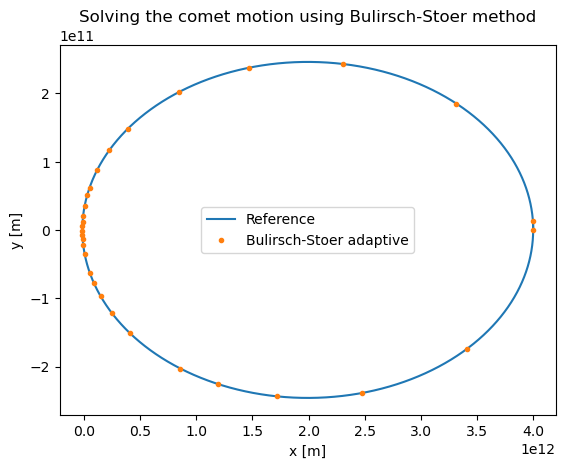

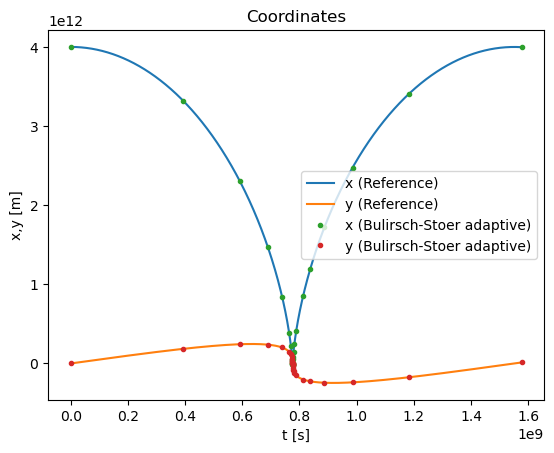

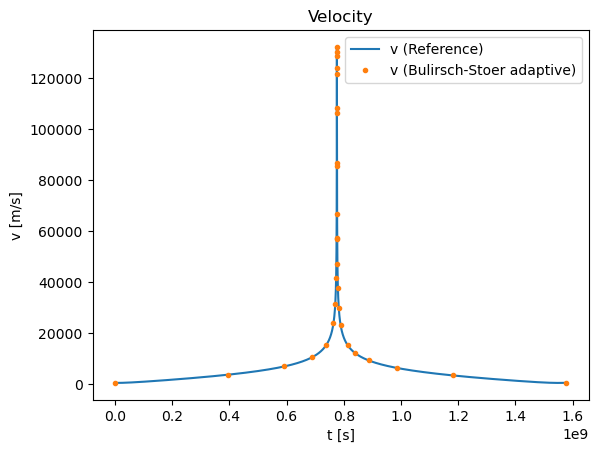

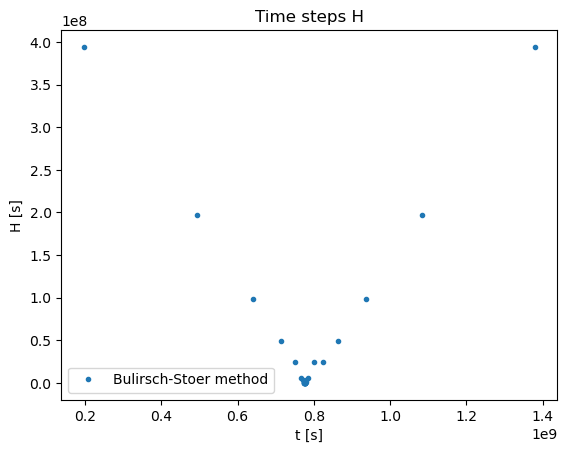

In [35]:
G = 6.67430e-11
Msun = 1.9885e30

def fcomet(xin, t):
    x = xin[0]
    y = xin[1]
    vx = xin[2]
    vy = xin[3]
    r = np.sqrt(x*x+y*y)
    return np.array([vx,vy,-G*Msun*x/r**3,-G*Msun*y/r**3])

def error_definition_comet(x1, x2):
    return np.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2)

x0 = [4.e12,0.,0.,500.]
a = 0.
b = 50. * 365. * 24. * 60. * 60.
N = 1
delta = 1. * 1.e3 / (365. * 24. * 60. * 60.)
sol = bulirsch_stoer(fcomet, x0, a, N, b, delta, error_definition_comet)

tpoints = [t for t in sol[0]]
xpoints = [x[0] for x in sol[1]]
ypoints = [x[1] for x in sol[1]]
vxpoints = [x[2] for x in sol[1]]
vypoints = [x[3] for x in sol[1]]
vpoints = [np.sqrt(x[2]*x[2] + x[3]*x[3]) for x in sol[1]]


plt.title("Solving the comet motion using Bulirsch-Stoer method")
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.plot(xpoints_rk4_ref,ypoints_rk4_ref,label='Reference')
plt.plot(xpoints,ypoints,'.',label='Bulirsch-Stoer adaptive')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

plt.title("Coordinates")
plt.xlabel('t [s]')
plt.ylabel('x,y [m]')
plt.plot(tpoints_rk4_ref,xpoints_rk4_ref,label='x (Reference)')
plt.plot(tpoints_rk4_ref,ypoints_rk4_ref,label='y (Reference)')
plt.plot(tpoints,xpoints,'.',label='x (Bulirsch-Stoer adaptive)')
plt.plot(tpoints,ypoints,'.',label='y (Bulirsch-Stoer adaptive)')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

plt.title("Velocity")
plt.xlabel('t [s]')
plt.ylabel('v [m/s]')
plt.plot(tpoints_rk4_ref,vpoints_rk4_ref,label='v (Reference)')
plt.plot(tpoints,vpoints,'.',label='v (Bulirsch-Stoer adaptive)')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

thpoints = []
hpoints = []
for i in range(len(tpoints) - 1):
    thpoints.append(0.5*(tpoints[i] + tpoints[i+1]))
    hpoints.append(tpoints[i+1] - tpoints[i])
    
plt.title("Time steps H")
plt.xlabel('t [s]')
plt.ylabel('H [s]')
plt.plot(thpoints,hpoints,'.',label='Bulirsch-Stoer method')
#plt.plot(tpoints,ypoints,label='y')
plt.legend()
plt.show()

## Example: SIR model

The SIR model is the simplest model for infectious disease dynamics in the population.
The population is split into susceptible ($S$), infected ($I$), and recovered/immune ($R$) parts.
The SIR equations read
\begin{align*}
\frac{dS}{dt} & = -\beta S I, \\
\frac{dI}{dt} & = \beta S I - \gamma I, \\
\frac{dR}{dt} & = \gamma I.
\end{align*}

Here $\beta$ is the infection rate and $\gamma$ is the recovery rate.
They are inversely proportional to the average time each infected person spreads the disease to (when all of population is susceptible, $S \approx 1$) and that it takes to recover. The ratio $R_0 = \beta / \gamma$ is the basic reproduction number.

Given that $S + I + R = 1 = \rm const$ at all times, one only needs to solve two ODEs, e.g. $dS/dt$ and $dI/dt$.

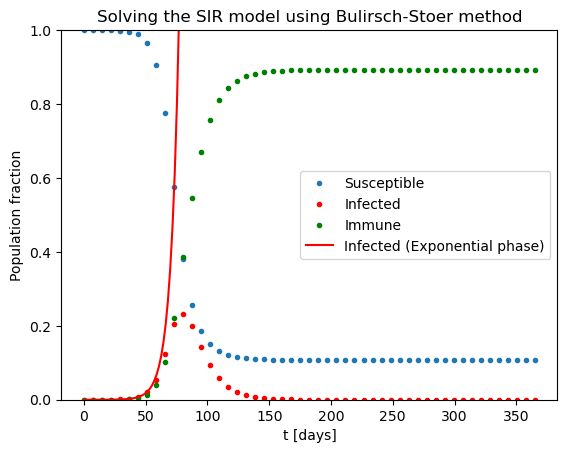

In [29]:
gam = 1./10.     # 10 days recovery rate
beta = 1./4.     # 4 days to infect other person
# R0 = beta/gam  # basic reproduction factor
kappa = 1. / 90. # immunity lasts for 90 days

def fSIR(xin, t):
    S = xin[0]
    I = xin[1]
    R = 1. - S - I
    return np.array([-beta * S * I, beta * I * S - gam * I])

t0 = 0.
tend = 365.

I0 = 1.e-5           # Initial fraction of infected
x0 = [1. - I0, I0]   # Initial conditions

delta = 1.e-9 # The desired accuracy per day
N = 50        # Minimum number of steps
sol = bulirsch_stoer(fSIR, x0, t0, N, tend, delta)

tpoints = [t for t in sol[0]]
Spoints = [x[0] for x in sol[1]]
Ipoints = [x[1] for x in sol[1]]
Rpoints = [1. - x[0] - x[1] for x in sol[1]]



#Nrk4 = 1000
#hrk4 = (tend - t0) / Nrk4
#sol = ode_rk4_multi(fSIR, x0, t0, hrk4, Nrk4)

# Exponential phase
texpon = np.linspace(0.,90.,50)
def fIexp(t):
    R0 = beta / gam
    return x0[1] * np.exp(gam*(R0-1.)*t)
Iexpon = fIexp(texpon)

plt.title("Solving the SIR model using Bulirsch-Stoer method")
plt.xlabel('t [days]')
plt.ylabel('Population fraction')
plt.ylim(0,1)
plt.plot(tpoints,Spoints,'.',label='Susceptible')
plt.plot(tpoints,Ipoints,'.',label='Infected',color='red')
plt.plot(tpoints,Rpoints,'.',label='Immune',color='green')
plt.plot(texpon,Iexpon,label='Infected (Exponential phase)',color='red')
plt.legend()
plt.show()

One can clearly see the initial exponential phase of the epidemic, and its end once a sufficient amount of population obtained immunity.

What if the immunity does not last forever but lost after some time (e.g. three months)?
One can add this effect into the equations through the corresponds loss of immunity rate $\kappa$:

\begin{align*}
\frac{dS}{dt} & = -\beta S I + \kappa R, \\
\frac{dI}{dt} & = \beta S I - \gamma I, \\
\frac{dR}{dt} & = \gamma I - \kappa R.
\end{align*}

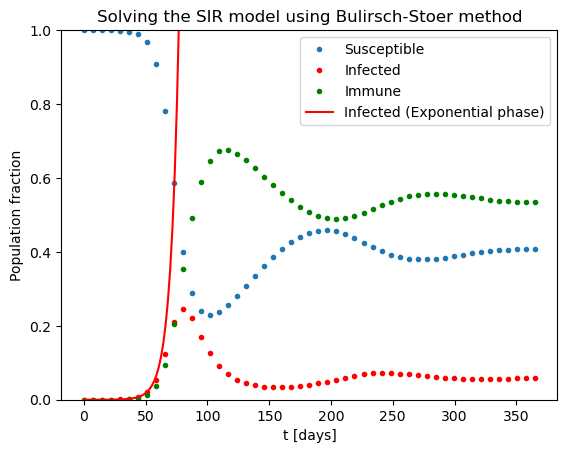

In [30]:
gam = 1./10.     # 10 days recovery rate
beta = 1./4.     # 4 days to infect other person
# R0 = beta/gam  # basic reproduction factor
immu = 1. / 90. # immunity lasts for 90 days

def fSIR(xin, t):
    S = xin[0]
    I = xin[1]
    R = 1. - S - I
    # print(xin)
    return np.array([-beta * S * I + immu * (1. - S - I), beta * I * S - gam * I])

t0 = 0.
tend = 365.

I0 = 1.e-5
x0 = [1. - I0, I0]

delta = 1.e-9 # The desired accuracy per day
N = 50
sol = bulirsch_stoer(fSIR, x0, t0, N, tend, delta)

tpoints = [t for t in sol[0]]
Spoints = [x[0] for x in sol[1]]
Ipoints = [x[1] for x in sol[1]]
Rpoints = [1. - x[0] - x[1] for x in sol[1]]


#Nrk4 = 1000
#hrk4 = (tend - t0) / Nrk4
#sol = ode_rk4_multi(fSIR, x0, t0, hrk4, Nrk4)

# Exponential phase
texpon = np.linspace(0.,90.,50)
def fIexp(t):
    R0 = beta / gam
    return x0[1] * np.exp(gam*(R0-1.)*t)
Iexpon = fIexp(texpon)

plt.title("Solving the SIR model using Bulirsch-Stoer method")
plt.xlabel('t [days]')
plt.ylabel('Population fraction')
plt.ylim(0,1)
plt.plot(tpoints,Spoints,'.',label='Susceptible')
plt.plot(tpoints,Ipoints,'.',label='Infected',color='red')
plt.plot(tpoints,Rpoints,'.',label='Immune',color='green')
plt.plot(texpon,Iexpon,label='Infected (Exponential phase)',color='red')
plt.legend()
plt.show()